## Import and connect to database

In [44]:
import pandas as pd
from scipy import stats
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import pi

conn = sqlite3.connect("data.db")
act = pd.read_sql_query("select rowid, * from actors where valid=1;", conn)

## Constants

In [78]:
def exp_format(x, pos=None):
    names = {1: 'Delay',
            2: 'Delay PD',
            3: 'No delay'}
    return names[x]

pair_dict2 = [{'aName':'Delay', 'bName':'Delay PD', 'a':0, 'b':1},
              {'aName':'Delay', 'bName':'No delay', 'a':0, 'b':2},
              {'aName':'Delay PD', 'bName':'No delay', 'a':1, 'b':2}]

### Significance, Paired sample t-test and Cohen's D

In [41]:
from numpy import std, mean, sqrt

def welch_dof(x,y):
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof

def dependent_dof(x,y):
    return (len(x)+len(y))/2-1

def cohen_d(x,y):
    x = x.tolist()
    y = y.tolist()
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

def print_sig(a, b, equal_var=False, dependent=True):
    if len(a) == len(b):
        t_stat, p_value = stats.ttest_rel(b, a)
        dof = dependent_dof(a, b)
    else:
        dependent = False
        t_stat, p_value = stats.ttest_ind(b, a, equal_var=equal_var)
        dof = welch_dof(a,b)
    d_value = cohen_d(b, a)

    if dependent:
        if p_value < 0.001:
            print('t({:.0f})={:.2f}, p$<$.001, d={:.3f}'.format(dof, t_stat, d_value))
        else:
            print('t({:.0f})={:.2f}, p={:.3f}, d={:.3f}'.format(dof, t_stat, p_value, d_value))
    else:
        if p_value < 0.001:
            print('t({:.2f})={:.2f}, p$<$.001, d={:.3f}'.format(dof, t_stat, d_value))
        else:
            print('t({:.2f})={:.2f}, p={:.3f}, d={:.3f}'.format(dof, t_stat, p_value, d_value))

## Recorded data

In [14]:
all_act = pd.read_sql_query("select * from actors where valid=1;", conn)
all_hits = pd.read_sql_query("select * from hits where valid=1;", conn)
all_survey = pd.read_sql_query("select * from survey where valid=1;", conn)
print('A total of {} data points were collected'.format(all_act.size+all_hits.size+all_survey.size))

A total of 11865 data points were collected


## Task times

In [15]:
times = pd.read_sql_query("select start, end from actors where valid=1;", conn)
length = np.array(times['end']-times['start'])
minutes = length.mean()/60-length.mean()/60%1
seconds = (length.mean()/60)%1*60
minutes_std = length.std()/60-length.std()/60%1
seconds_std = (length.std()/60)%1*60

print('Subjects used on average {:.0f} minutes and {:.0f} seconds with a standard deviation of {:.0f}min and {:.0f}s'
     .format(minutes, seconds, minutes_std, seconds_std))

Subjects used on average 10 minutes and 56 seconds with a standard deviation of 1min and 12s


## Demographics

In [12]:
valid_n = len(pd.read_sql_query("select age, gender, education, computer, eye from actors where valid=1;", conn))
non_valid = pd.read_sql_query("select age, gender, education, computer, eye from actors where valid=0;", conn)
female = pd.read_sql_query("select age, gender, education, computer, eye from actors where gender=1 and valid=1;", conn)
male = pd.read_sql_query("select age, gender, education, computer, eye from actors where gender=0 and valid=1;", conn)
ages_df = pd.read_sql_query("select age from actors where valid=1;", conn)
ages = np.array(ages_df)
game = []
frequency = ['Daily', 'Weekly', 'Monthly', 'Yearly', 'Never']
print('Gaming:')
for i in range(5):
    query = "select * from actors where valid=1 and game={};".format(i)
    n_people = len(pd.read_sql_query(query, conn))
    print('{}: {}, {:.1f}'.format(frequency[i], n_people, n_people/valid_n*100))


print('{} total participants, {} excluded'.format(valid_n+len(non_valid),len(non_valid) ))
print('{} males {:.1f}, {} females {:.1f}'.format(len(male), len(male)/valid_n*100, len(female), len(female)/valid_n*100))
# print('{:.1f}% females'.format(len(female)/valid_n*100))
print('Average age of {:.1f} years with a SD of {:.2f}'.format(float(ages.mean(axis=0)), float(ages.std(axis=0))))
print('100% said they use computer on a daily basis ')
# print('Gaming: daily {:.0f}%, weekly {:.0f}%, monthly {:.0f}%, yearly {:.0f}% and never {:.0f}%'.format(*[i/valid_n*100 for i in game]))

Gaming:
Daily: 2, 3.5
Weekly: 15, 26.3
Monthly: 8, 14.0
Yearly: 17, 29.8
Never: 15, 26.3
58 total participants, 1 excluded
38 males 66.7, 19 females 33.3
Average age of 24.7 years with a SD of 1.45
100% said they use computer on a daily basis 


# Performance normalized

In [148]:
def output_statistical_information(normalized_values, group_name='All', subset=False):
    """
    Parameters
    ----------
    normalized_values : a Nx3 numpy matrix with normalized values
    
    group_name : str with the group or subgroup
    
    subset : if subset, it will print "n" instead of "N"
    """
    if subset:
        n = 'n'
    else:
        n = 'N'
    
    norm = normalized_values
    display_means = norm.mean(axis=0)
    display_std = norm.std(axis=0)
    display_max = norm.max(axis=0)
    display_min = norm.min(axis=0)
    print('{} {}={}'.format(group_name, n, len(norm)))
    print('\tScore\n')
    for exp_idx in range(3):
        print('\t{:<10} Mean: {:>5.2f}, SD: {:>.2f}'
              .format(exp_format(exp_idx+1), display_means[exp_idx], display_std[exp_idx]))

    print('\n\tPaired difference\n')
    for di in pair_dict2:
        a = norm[...,di['a']]
        b = norm[...,di['b']]

        print('\t{:<10}- {:<10}'.format(di['aName'], di['bName']), end='')
        print('\t{:>6.2f}\%     '.format((b.mean()/a.mean()-1)*100), end='')
        print_sig(a,b)
    print('')
    

def boxplot(normalized_values, filename=None):
    """
    Parameters
    ----------
    normalized_values : a Nx3 numpy matrix with normalized values
    
    filename : str, if defined figure will be saved
    """
    norm = normalized_values
    fig, ax = plt.subplots(figsize=(4,4))
    ax.boxplot(norm, whis=2, widths=0.5)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
    plt.ylabel('Score')
    plt.show()
    if filename:
        fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')
        
def normalize_array(array):
    """
    Parameters
    ----------
    array : a Nx3 numpy matrix
    
    Returns
    -------
    array : a Nx3 numpy matrix with normalized values
    """
    hits = array
    total_mean = hits.mean()
    norm = np.zeros((hits.shape[0],3))
    for i, row in enumerate(hits):
        user_mean = np.array([row[0], row[1], row[2]]).mean()
        norm[i,0] = row[0]/user_mean*total_mean
        norm[i,1] = row[1]/user_mean*total_mean
        norm[i,2] = row[2]/user_mean*total_mean
    return norm
    

### All

All N=57
	Score

	Delay      Mean:  6.24, SD: 1.39
	Delay PD   Mean:  7.52, SD: 1.43
	No delay   Mean: 15.87, SD: 1.99

	Paired difference

	Delay     - Delay PD  	 20.62\%     t(56)=4.80, p$<$.001, d=0.904
	Delay     - No delay  	154.37\%     t(56)=23.15, p$<$.001, d=5.569
	Delay PD  - No delay  	110.88\%     t(56)=19.66, p$<$.001, d=4.772



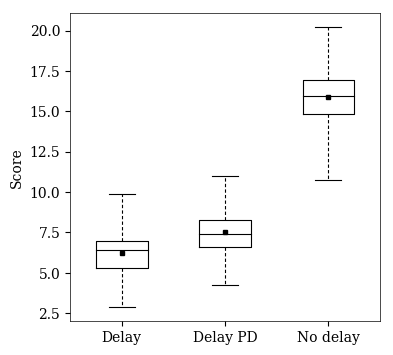

In [149]:
hits = np.array(pd.read_sql_query("select tothitsexp0, tothitsexp1, tothitsexp2 from actors where valid=1;", conn))
norm = normalize_array(hits)
output_statistical_information(norm)
boxplot(norm, 'performance_norm')

### Gender

In [117]:
genders = ['Male', 'Female']

for gender_idx, gender in enumerate(genders):
    hits = np.array(pd.read_sql_query("select tothitsexp0, tothitsexp1, tothitsexp2 from actors where gender={} and valid=1;"
                                      .format(gender_idx), conn))
    norm = normalize_array(hits)        
    output_statistical_information(norm, gender, True)

Male n=38
	Score

	Delay      Mean:  6.65, SD: 1.25
	Delay PD   Mean:  7.95, SD: 1.43
	No delay   Mean: 17.30, SD: 1.71

	Paired difference

	Delay     - Delay PD  	 19.62\%     t(37)=3.84, p$<$.001, d=0.960
	Delay     - No delay  	160.31\%     t(37)=24.66, p$<$.001, d=7.031
	Delay PD  - No delay  	117.61\%     t(37)=19.67, p$<$.001, d=5.861

Female n=19
	Score

	Delay      Mean:  5.39, SD: 1.49
	Delay PD   Mean:  6.61, SD: 1.35
	No delay   Mean: 13.10, SD: 2.17

	Paired difference

	Delay     - Delay PD  	 22.57\%     t(18)=2.82, p=0.011, d=0.835
	Delay     - No delay  	142.85\%     t(18)=9.43, p$<$.001, d=4.033
	Delay PD  - No delay  	 98.14\%     t(18)=8.35, p$<$.001, d=3.495



### Gaming

In [118]:
gamers = ['Daily', 'Weekly', 'Montly', 'Yearly', 'Never']

for gamer_idx, gamer in enumerate(gamers):
    hits = np.array(pd.read_sql_query("select tothitsexp0, tothitsexp1, tothitsexp2 from actors where game={} and valid=1;"
                                      .format(gamer_idx), conn))
    norm = normalize_array(hits)        
    output_statistical_information(norm, gamer, True)

Daily n=2
	Score

	Delay      Mean:  7.92, SD: 0.37
	Delay PD   Mean: 10.21, SD: 1.40
	No delay   Mean: 18.36, SD: 1.77

	Paired difference

	Delay     - Delay PD  	 28.88\%     t(1)=2.22, p=0.269, d=1.578
	Delay     - No delay  	131.77\%     t(1)=4.87, p=0.129, d=5.762
	Delay PD  - No delay  	 79.83\%     t(1)=2.57, p=0.236, d=3.606

Weekly n=15
	Score

	Delay      Mean:  6.27, SD: 1.22
	Delay PD   Mean:  8.17, SD: 1.51
	No delay   Mean: 17.62, SD: 2.04

	Paired difference

	Delay     - Delay PD  	 30.32\%     t(14)=3.85, p=0.002, d=1.336
	Delay     - No delay  	180.98\%     t(14)=14.18, p$<$.001, d=6.534
	Delay PD  - No delay  	115.62\%     t(14)=10.48, p$<$.001, d=5.090

Montly n=8
	Score

	Delay      Mean:  7.05, SD: 1.32
	Delay PD   Mean:  7.77, SD: 0.64
	No delay   Mean: 17.68, SD: 0.95

	Paired difference

	Delay     - Delay PD  	 10.26\%     t(7)=1.04, p=0.334, d=0.652
	Delay     - No delay  	150.84\%     t(7)=12.76, p$<$.001, d=8.660
	Delay PD  - No delay  	127.51\%     t(7)=2

### Gamers vs non gamers

In [121]:
gamers = np.array(pd.read_sql_query("select tothitsexp0, tothitsexp1, tothitsexp2 from actors where valid=1 and game<=1;", conn))
non_gamers = np.array(pd.read_sql_query("select tothitsexp0, tothitsexp1, tothitsexp2 from actors where valid=1 and game>1;", conn))

output_statistical_information(normalize_array(gamers), 'Gamers', True)
output_statistical_information(normalize_array(non_gamers), 'Non gamers', True)

Gamers n=17
	Score

	Delay      Mean:  6.46, SD: 1.19
	Delay PD   Mean:  8.40, SD: 1.53
	No delay   Mean: 17.73, SD: 2.08

	Paired difference

	Delay     - Delay PD  	 30.13\%     t(16)=4.34, p$<$.001, d=1.376
	Delay     - No delay  	174.64\%     t(16)=14.93, p$<$.001, d=6.463
	Delay PD  - No delay  	111.05\%     t(16)=10.83, p$<$.001, d=4.965

Non gamers n=40
	Score

	Delay      Mean:  6.12, SD: 1.41
	Delay PD   Mean:  7.16, SD: 1.39
	No delay   Mean: 15.09, SD: 1.93

	Paired difference

	Delay     - Delay PD  	 16.91\%     t(39)=3.20, p=0.003, d=0.731
	Delay     - No delay  	146.46\%     t(39)=18.16, p$<$.001, d=5.237
	Delay PD  - No delay  	110.80\%     t(39)=16.21, p$<$.001, d=4.655



## Load index

#### Absolute

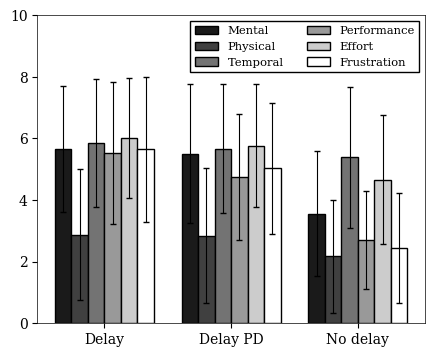

Mental N=57
	Score

	Delay      Mean:  5.67, SD: 2.05
	Delay PD   Mean:  5.51, SD: 2.25
	No delay   Mean:  3.56, SD: 2.03

	Paired difference

	Delay     - Delay PD  	 -2.79\%     t(56)=-0.67, p=0.504, d=-0.073
	Delay     - No delay  	-37.15\%     t(56)=-9.31, p$<$.001, d=-1.025
	Delay PD  - No delay  	-35.35\%     t(56)=-6.36, p$<$.001, d=-0.902

Physical N=57
	Score

	Delay      Mean:  2.88, SD: 2.14
	Delay PD   Mean:  2.84, SD: 2.19
	No delay   Mean:  2.18, SD: 1.84

	Paired difference

	Delay     - Delay PD  	 -1.22\%     t(56)=-0.16, p=0.874, d=-0.016
	Delay     - No delay  	-24.39\%     t(56)=-3.10, p=0.003, d=-0.349
	Delay PD  - No delay  	-23.46\%     t(56)=-3.15, p=0.003, d=-0.327

Temporal N=57
	Score

	Delay      Mean:  5.84, SD: 2.08
	Delay PD   Mean:  5.67, SD: 2.10
	No delay   Mean:  5.39, SD: 2.30

	Paired difference

	Delay     - Delay PD  	 -3.00\%     t(56)=-0.79, p=0.431, d=-0.083
	Delay     - No delay  	 -7.81\%     t(56)=-1.93, p=0.059, d=-0.206
	Delay PD  - No del

In [130]:
tlx_metrics = ['Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration']
filename = 'nasa_tlx_bar'
plt.style.use('default')
plt.style.use('thesis.mplstyle')

n_partic = pd.read_sql_query("select rowid from actors where valid=1 ;", conn).size
fig1, ax1 = plt.subplots(figsize=(5,4))
tlx_answers = []

bar_width= 0.13

for idx, metric in enumerate(tlx_metrics):
    data = np.zeros([n_partic,3])
    for exp in range(3):
        load = pd.read_sql_query("select {} from survey where valid=1 and experiment={};"
                                 .format(metric, exp), conn)
        data[...,exp] = np.reshape(np.array(load),(57,))
    if metric == 'Performance':
        data = np.ones_like(data)*10-data
    mean_ = data.mean(axis=0)
    std_ = data.std(axis=0)
    x_pos = np.arange(3)+1 - bar_width*3 +idx*bar_width+bar_width/2
    tlx_answers.append(data)
    
    ax1.bar(x_pos, mean_, bar_width, yerr=std_, label=metric, 
            edgecolor='k', 
            linewidth=1,
           capsize=2,
           error_kw={'linewidth':0.8})


ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
ax1.set_xticks(np.arange(3)+1)
plt.ylim(0,10)
plt.legend(ncol=2, fontsize='small')
plt.show()
# fig1.savefig('../img/{}.png'.format(filename), bbox_inches='tight')
for idx, metric in enumerate(tlx_answers):
    output_statistical_information(metric, tlx_metrics[idx])

#### Significance

In [316]:
metric = 0
g0 = tlx_answers[metric][...,1]
g1 = tlx_answers[metric][...,2]
print_sig(g1, g0)
answers_means = np.copy(tlx_answers[metric]).mean(axis=0)
print(answers_means)
print('{:.0f}% decrease in subjective latency using predictor screen'.format((1-answers_means[1]/answers_means[0])*100))

t(56)=6.36, p$<$.001, d=0.902
[5.66666667 5.50877193 3.56140351]
3% decrease in subjective latency using predictor screen


### Subjective delay vs frustration

$R^2=0.01$, p=0.20669, err=0.00058


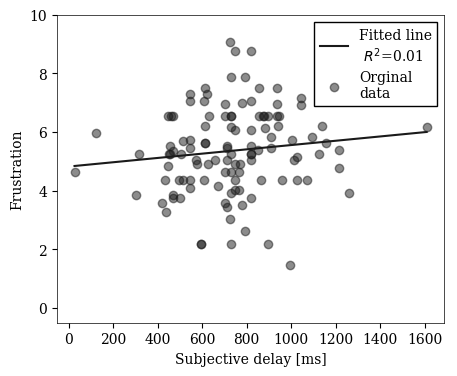

In [176]:
def avg_actor_delay(id):
    avg_delay = np.array(pd.read_sql_query("select delay from survey where valid=1 and actor={}".format(id), conn)).mean()
    return avg_delay

def avg_actor_frustration(id):
    avg_frus = np.array(pd.read_sql_query("select frustration from survey where valid=1 and actor={}".format(id), conn)).mean()
    return avg_frus

total_avg_frustration = np.array(pd.read_sql_query("select frustration from survey where valid=1", conn)).mean()
total_avg_delay = np.array(pd.read_sql_query("select delay from survey where valid=1", conn)).mean()

act = pd.read_sql_query("select rowid, * from actors where valid=1;", conn)
actor_ids = act.rowid.values
answ = [[],[]]

normalize = True
sel_exp = [0,1]
filename = 'delay_vs_frustration'

for actor_id in actor_ids:
    avg_delay = avg_actor_delay(actor_id)
    avg_frustration = avg_actor_frustration(actor_id)
    for exp in range(3):
        sur = pd.read_sql_query("select frustration, delay from survey where valid=1 and actor={} and experiment={}"
                                .format(actor_id, exp), conn)
        if normalize:
            frustration = float(sur['frustration'])/avg_frustration*total_avg_frustration
            delay = float(sur['delay'])/avg_delay*total_avg_delay
        else:
            frustration = float(sur['frustration'])
            delay = float(sur['delay'])
            
        if sel_exp is None or exp in sel_exp:
            answ[0].append(frustration)
            answ[1].append(delay)

x = answ[1]
y = answ[0]

linreg = stats.linregress(x,y)
# print(linreg)
x_min = min(x)
x_max = max(x)
print('$R^2={:.2f}$, p={:.5f}, err={:.5f}'.format(linreg.rvalue**2, linreg.pvalue, linreg.stderr))

plt.style.use('default')
plt.style.use('thesis.mplstyle')
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(x,y, marker='o', alpha=0.5, label='Orginal\ndata')
ax.plot(np.arange(x_min, x_max), np.arange(x_min, x_max)*linreg.slope+linreg.intercept, label='Fitted line\n $R^2$={:.2f}'
        .format(linreg.rvalue**2))
ax.legend()
plt.ylabel('Frustration')
plt.xlabel('Subjective delay [ms]')
plt.ylim([-0.5,10])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

### Subjective frustration vs performance

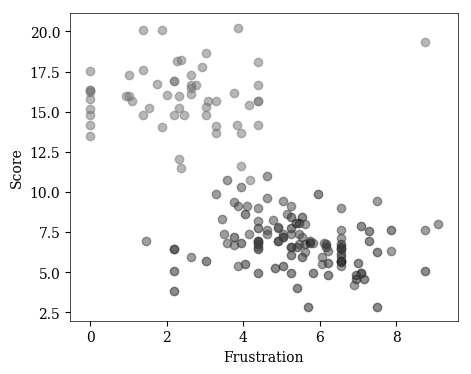

In [169]:
hits_id = np.array(pd.read_sql_query("select rowid from actors where valid=1;", conn))
hits = np.array(pd.read_sql_query("select tothitsexp0, tothitsexp1, tothitsexp2 from actors where valid=1;", conn))
hits_norm = normalize_array(hits)
frustration = []
for actor_id in hits_id:
    rated = []
    for exp in range(3):
        v = pd.read_sql_query("select frustration from survey where valid=1 and actor={} and experiment={};"
                                       .format(int(actor_id), exp), conn)
        rated.append(int(v['frustration']))
    frustration.append(rated)
frus = np.array(frustration)
frus_norm = normalize_array(frus)

fig, ax = plt.subplots(figsize=(5,4))
for exp in range(3):
    x = frus_norm[...,exp]
    y = hits_norm[...,exp]
    
    ax.scatter(x,y, marker='o', alpha=0.5, label=exp)
    plt.ylabel('Score')
    plt.xlabel('Frustration')
plt.show()

## Delay times

In [100]:
data = pd.DataFrame()
for exp in range(3):
    data[exp] = pd.read_sql_query("select delay from survey where valid=1 and experiment={} order by actor asc;".format(exp), conn)
times = np.array(data)

### Absolute

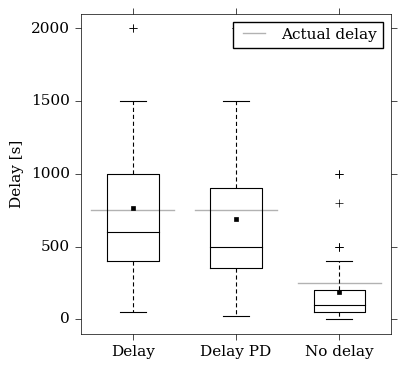

In [101]:
filename = 'subjective_delay_abs'
matplotlib.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(times, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
ax.plot([0.6,1.4], [750, 750], 'k', alpha=0.3, label='Actual delay')
ax.plot([1.6,2.4], [750, 750], 'k', alpha=0.3)
ax.plot([2.6,3.4], [250, 250], 'k', alpha=0.3)
ax.legend()
plt.ylabel('Delay [s]')
plt.ylim([-100,2100])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

### Normalized

In [103]:
sums = times.sum(axis=1)
averages = np.copy(times).mean(axis=0)
total_delay_average = np.copy(times).mean()
normalized = np.copy(times)
for idx, row in enumerate(normalized):
    user_avg = np.array([row[0], row[1], row[2]]).mean()
    row[0] = row[0]/user_avg*total_delay_average
    row[1] = row[1]/user_avg*total_delay_average
    row[2] = row[2]/user_avg*total_delay_average

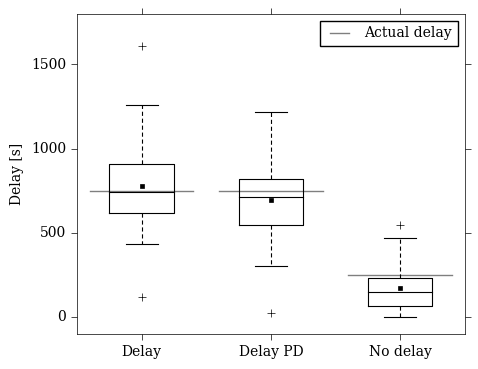

In [104]:
plt.style.use('classic')
plt.style.use('thesis.mplstyle')
filename = 'subjective_delay_norm'
fig, ax = plt.subplots(figsize=(5,4))
ax.boxplot(normalized, widths=0.5)
ax.plot([0.6,1.4], [750, 750], 'k', alpha=0.5, label='Actual delay')
ax.plot([1.6,2.4], [750, 750], 'k', alpha=0.5)
ax.plot([2.6,3.4], [250, 250], 'k', alpha=0.5)
ax.legend()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Delay [s]')
plt.ylim([-100,1800])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

In [244]:
norm_avg = np.copy(normalized).mean(axis=0)
print('{:.0f}% decrease in subjective latency using predictor screen'.format((1-norm_avg[1]/norm_avg[0])*100))
print_sig(normalized[...,1], normalized[...,0])

11% decrease in subjective latency using predictor screen
t(56)=1.40, p=0.167, d=0.356


## Key presses

In [95]:
data = pd.read_sql_query("select keydowns0, keydowns1, keydowns2 from actors where valid=1;", conn)
keys = np.array(data)

#### Absolute

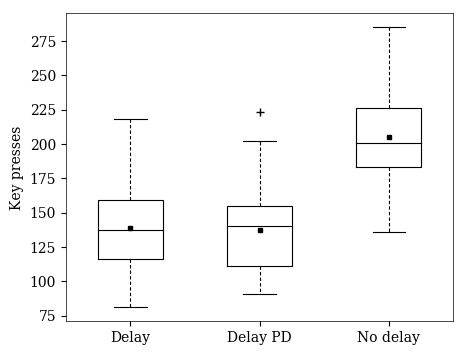

In [96]:
filename = 'keypresses'
matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(5,4))
ax.boxplot(keys, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Key presses')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

## Learning effect

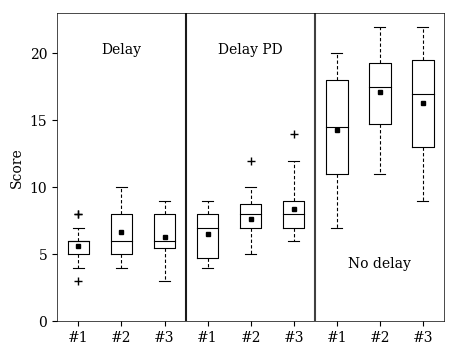

In [93]:
def condition_format(x, pos=None):
    names = ['#1', '#2', '#3']*3
    return names[x-1]

filename = 'learning_effect'

pos = [[0,1,2,4,3,5],
      [2,3,0,5,1,4],
      [4,5,1,3,0,2]]

all_li = []

for exp in range(3):
    first = pd.read_sql_query("select tothitsexp{} from actors where valid=1 and crowd={} or crowd={};"
                              .format(exp, pos[exp][0], pos[exp][1]), conn)
    middle = pd.read_sql_query("select tothitsexp{} from actors where valid=1 and crowd={} or crowd={};"
                              .format(exp, pos[exp][2], pos[exp][3]), conn)
    last = pd.read_sql_query("select tothitsexp{} from actors where valid=1 and crowd={} or crowd={};"
                              .format(exp, pos[exp][4], pos[exp][5]), conn)

    li = [first['tothitsexp'+str(exp)], middle['tothitsexp'+str(exp)],last['tothitsexp'+str(exp)]]
    all_li.extend(li)

fig, ax = plt.subplots(figsize=(5,4))
ax.boxplot([list(i) for i in all_li])
ax.plot([3.5, 3.5],[0,23])
ax.plot([6.5, 6.5],[0,23])
plt.ylabel('Score')
plt.text(2, 20, 'Delay', fontsize=10, ha='center')
plt.text(5, 20, 'Delay PD', fontsize=10, ha='center')
plt.text(8, 4, 'No delay', fontsize=10, ha='center')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(condition_format))
plt.ylim([0,23])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

In [142]:
num1 = 6
num2 = num1+1
ns = min(len(all_li[num1]), len(all_li[num2]))
print(ns)

print_sig(all_li[num1][:ns], all_li[num2][:ns])

18
t(17)=3.26, p=0.005, d=0.902


In [181]:
for group in range(6):
    hits = pd.read_sql_query("select tothitsexp0, tothitsexp1, tothitsexp2 from actors where valid=1 and crowd={};".format(group), conn)
    norm = normalize_array(np.array(hits))
    output_statistical_information(norm, 'Group {}'.format(group), True)

Group 0 n=9
	Score

	Delay      Mean:  5.08, SD: 1.21
	Delay PD   Mean:  7.40, SD: 1.13
	No delay   Mean: 15.40, SD: 1.83

	Paired difference

	Delay     - Delay PD  	 45.58\%     t(8)=4.49, p=0.002, d=1.867
	Delay     - No delay  	203.00\%     t(8)=10.11, p$<$.001, d=6.274
	Delay PD  - No delay  	108.13\%     t(8)=8.11, p$<$.001, d=4.960

Group 1 n=10
	Score

	Delay      Mean:  6.24, SD: 0.72
	Delay PD   Mean:  8.45, SD: 0.96
	No delay   Mean: 17.41, SD: 1.02

	Paired difference

	Delay     - Delay PD  	 35.42\%     t(9)=4.89, p$<$.001, d=2.474
	Delay     - No delay  	179.12\%     t(9)=22.73, p$<$.001, d=12.050
	Delay PD  - No delay  	106.11\%     t(9)=14.59, p$<$.001, d=8.602

Group 2 n=10
	Score

	Delay      Mean:  6.65, SD: 1.15
	Delay PD   Mean:  6.32, SD: 1.03
	No delay   Mean: 17.04, SD: 1.51

	Paired difference

	Delay     - Delay PD  	 -4.98\%     t(9)=-0.63, p=0.544, d=-0.288
	Delay     - No delay  	156.29\%     t(9)=12.57, p$<$.001, d=7.347
	Delay PD  - No delay  	169.73\%  

## Gamers

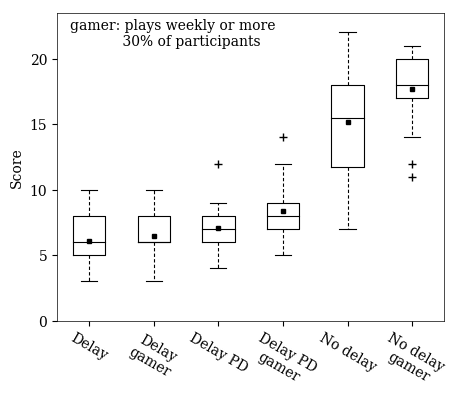

In [122]:
def game_format(x, pos=None):
    names = {1: 'Delay',
             2: 'Delay\ngamer',
            3: 'Delay PD',
            4: 'Delay PD\ngamer',
            5: 'No delay',
            6: 'No delay\ngamer'}
    return names[x]

gamers = pd.read_sql_query("select rowid, * from actors where valid=1 and game<=1;", conn)
ga = np.array(gamers[['tothitsexp0', 'tothitsexp1', 'tothitsexp2']])
non_gamers = pd.read_sql_query("select rowid, * from actors where valid=1 and game >1;", conn)
no = np.array(non_gamers[['tothitsexp0', 'tothitsexp1', 'tothitsexp2']])

game_per = len(gamers)/(len(gamers)+len(non_gamers))

filename = 'gamer_performance'
fig1, ax1 = plt.subplots(figsize=(5,4))
# ax1.set_title('Performance gamers vs non gamers')
ax1.boxplot([no[...,0], ga[...,0], no[...,1], ga[...,1], no[...,2], ga[...,2]])
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(game_format))
plt.ylabel('Score')
plt.text(0.7, 21, 'gamer: plays weekly or more\n            {:.0f}% of participants'.format(game_per*100), fontsize=10)
plt.xticks(rotation=-30)
plt.ylim([0,23.5])
plt.show()
# fig1.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

In [157]:
exp = 2
print_sig(no[...,0], no[...,1])
print_sig(ga[...,0], ga[...,1])

t(39)=3.27, p=0.002, d=0.577
t(16)=4.17, p<.001, d=1.018
